This notebook follows the creation and testing of a neural network to classify numbers on the MNIST database. The data is stored in a database created using SQL Server. 

In [97]:
import pyodbc 
import pandas as pd
import numpy as np
#connecting to SQL database. Since I'm using a developer SQL instance 
# on my own computer I'm happy to not worry about encrytion and trust the server certificate
cnxn_str = ("Driver={ODBC Driver 18 for SQL Server};"
            "Server=AMINS-COMPUTER;"
            "Database=master;"
            "Trusted_Connection=yes;"
            "TrustServerCertificate=YES;")
cnxn = pyodbc.connect(cnxn_str)
mnistTest = pd.read_sql("SELECT * FROM mnistTableTest",cnxn)
mnistTrain = pd.read_sql("SELECT * FROM mnistTableTrain",cnxn)
mnistTest[0:5]

C:\Users\gulam\AppData\Local\Temp\ipykernel_13328\3476443618.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  mnistTest = pd.read_sql("SELECT * FROM mnistTableTest",cnxn)
C:\Users\gulam\AppData\Local\Temp\ipykernel_13328\3476443618.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  mnistTrain = pd.read_sql("SELECT * FROM mnistTableTrain",cnxn)


,digit,Px1,Px2,Px3,Px4,Px5,Px6,Px7,Px8,Px9,...,Px776,Px777,Px778,Px779,Px780,Px781,Px782,Px783,Px784,ID
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5


In [98]:
#preprocessing dataset
trainlabels = mnistTrain['digit']
testlabels = mnistTest['digit']
mnistTest = mnistTest.drop(columns=['digit','ID'])
mnistTrain = mnistTrain.drop(columns=['digit','ID'])


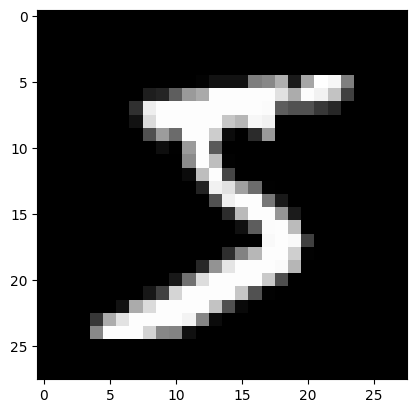

In [99]:
import matplotlib.pyplot as plt
mnistTrain = mnistTrain.to_numpy().reshape(60000,28,28)
mnistTest = mnistTest.to_numpy().reshape(10000,28,28)
plt.imshow(mnistTrain[0:1].reshape(28,28), cmap='gray')


In [122]:
import os
dir = "C:/Users/gulam/Documents/Git/Solo-learning/MNIST NN w SQL & PyTorch/"
testpath = dir + "testImgs"
trainpath = dir + "trainImgs"
#os.mkdir(testpath)
#os.mkdir(trainpath)

In [116]:
trainlabels

0        5
1        2
2        5
3        4
4        9
        ..
59995    1
59996    2
59997    2
59998    7
59999    3
Name: digit, Length: 60000, dtype: int64

In [121]:
import matplotlib.image as image
#saving images locally
def listsave(dataset,dir):
    for i in range (0,len(dataset)):
        image.imsave(dir + "/{}.png".format(i),dataset[i:i+1].reshape(28,28), cmap='gray')
        if i % 1000 == 0:
            print("image {} saved".format(i))

listsave(mnistTest,testpath)
print("testimgs saved")
listsave(mnistTrain,trainpath)
print("trainimgs saved")
trainlabels.to_csv('trainlabels.csv')
testlabels.to_csv('testlabels.csv')

image 0 saved
image 1000 saved
image 2000 saved
image 3000 saved
image 4000 saved
image 5000 saved
image 6000 saved
image 7000 saved
image 8000 saved
image 9000 saved
testimgs saved
image 0 saved
image 1000 saved
image 2000 saved
image 3000 saved
image 4000 saved
image 5000 saved
image 6000 saved
image 7000 saved
image 8000 saved
image 9000 saved
image 10000 saved
image 11000 saved
image 12000 saved
image 13000 saved
image 14000 saved
image 15000 saved
image 16000 saved
image 17000 saved
image 18000 saved
image 19000 saved
image 20000 saved
image 21000 saved
image 22000 saved
image 23000 saved
image 24000 saved
image 25000 saved
image 26000 saved
image 27000 saved
image 28000 saved
image 29000 saved
image 30000 saved
image 31000 saved
image 32000 saved
image 33000 saved
image 34000 saved
image 35000 saved
image 36000 saved
image 37000 saved
image 38000 saved
image 39000 saved
image 40000 saved
image 41000 saved
image 42000 saved
image 43000 saved
image 44000 saved
image 45000 saved
ima

In [ ]:
#creating custom dataset
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
testset = CustomImageDataset(dir + "testlabels.csv", testpath)
trainset = CustomImageDataset(dir + "trainlabels.csv", trainpath)

In [ ]:
#Building CNN Neurons
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 options 0,1,2,3,4,5,6,7,8,9
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization
cnn = CNN()
print(cnn)

In [ ]:
#function definition
loss_func = nn.CrossEntropyLoss()
from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)   
optimizer

In [ ]:
#training
from torch.autograd import Variable
num_epochs = 10
def train(num_epochs, cnn, loaders):
    
    cnn.train()
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]               
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
            pass
        
        pass
    
    
    pass
train(num_epochs, cnn, loaders)

In [ ]:
import torch
def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
    print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)
test()

In [71]:
from sklearn import preprocessing
mnistTrain = preprocessing.minmax_scale(mnistTrain, feature_range=(0, 1), axis=0)
mnistTest = preprocessing.minmax_scale(mnistTest, feature_range=(0, 1), axis=0)

NameError: name 'typeOf' is not defined

,digit,Px1,Px2,Px3,Px4,Px5,Px6,Px7,Px8,Px9,...,Px775,Px776,Px777,Px778,Px779,Px780,Px781,Px782,Px783,Px784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
